# Simple galaxy fitting with KinMS

This tutorial aims at getting you up and running with simple galaxy kinematic modelling using KinMS! To start you will need to download the KinMSpy code and have it in your python path. 

To do this you can simply call `pip install kinms`.

You also need the KinMS_fitter routines, which can be found in this repository. 

To get started with kinematic modelling we will complete the following steps:
1. Generate a model to fit (can be skipped if you have your own observed data cube)
2. Read that cube in with KinMS_fitter, and provide some initial guess for parameters.
3. Get fitting!



## Generate a model

Here we will use one of the KinMS test suite routines to generate a simple mock datacube that we can use to test our fitting. 


The `expdisk` function from the test suite creates a disc with an exponential surface brightness profile, and  a rotation curve that has a linear rise in the centre, and then is flat. This disc is observed with a 4$^{\prime\prime}$ beam, and has an extent and inclination that can be set by the user. See the other KinMS tutorials, and the test suite itself for full details.

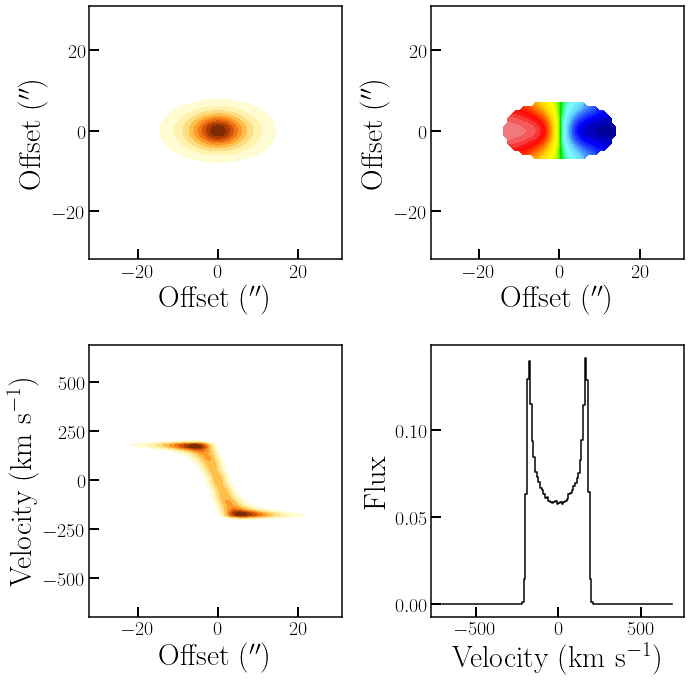

In [1]:
from kinms.examples.KinMS_testsuite import expdisk

data=expdisk(fileName='Output',scalerad=5, inc=60)

This has now created the mock datacube, named 'Output_simcube.fits' in our directory, so we can proceed with `KinMS_fitter`.

## Fitting with KinMS_fitter

### Philosophy of KinMS_fitter

KinMS_fitter has been designed to be as simple as possible. If run with all parameters at their defaults it will:

* Assume the gas surface brightness profile has an exponential form
* Assume you want to fit the velocity curve freely in individual beam-sized apertures (tilted-ring style)
* Fit the free parameters of the above, along with the geometric paramters of the disc (PA, inclination), and the typical nuisance paramters (kinematic centre in RA, Dec, Vsys; and the total flux of the system)

By using other parameters one can in a simple way:

* Use parameterized rotation curves (e.g. arctan models, Kelpalrians, disc/bulge, etc) or rotation curves from MGE models, AND combinations of these.
* Use more complex surface brightness parameterisations (rings, holes, etc)  AND combinations of these.

First here will we demonstrate the simple case.


We begin by importing KinMS_fitter:

In [2]:
from kinms_fitter import kinms_fitter

Now we can load in the datacube.

In [3]:
fit=kinms_fitter('Output_simcube.fits')

As our datacube is a bit bigger than our actual source, for speed we may want to cut down the cube. Ideal sizes are $2^N$, but you can experiment with your own sources. KinMS will tell you how long a single model takes to generate, so you can optimise this. 

`spatial_trim` cuts your cube in the spatial directions, and needs to be a 4 element vector of the form [start_x, end_x, start_y, end_y]

`spectral_trim` shows what channels to include. Here our signal is between channel ~47 and 93. We want to ensure we have some line-free channels on either end, but not too many.

`linefree_chans` allows you to tell the code where to estimate the RMS - it defaults to channels 1 -> 6.

Given the above, the line below will be a better choice for our datacube than leaving everything at its defaults.

In [4]:
fit=kinms_fitter('Output_simcube.fits',spatial_trim=[16,48,16,48],spectral_trim=[43,98],linefree_chans=[30,45])

Now we can provide initial guesses for parameters, if we wish. The code attempts to set sensible defaults, but these are not perfect. Below we set guesses for the position angle only (see later for a full list of possibilities).

In [5]:
fit.pa_guess=90

Given we are using the simple "tilted-ring" type model for velocities, its also crucial to set the hyperparameter `nrings`. This is the number of beam size elements you have across your galaxy. Set this too large and it will do crazy things in the outer parts where it isnt constrained!

In [10]:
fit.nrings=5

One last thing - because we are fitting to noiseless model data here, the RMS estimated from the cube in the standard way is zero! (You can see this by printing `fit.rms`). In this case we will set a mock RMS. Doing this could also sensible if you want to override the autoestimate of the code for other reasons.

In [11]:
fit.rms=1e-3

Now we are ready to run a simple fit! By default this uses an MCMC with 3000 steps to find your best-fit model, and constrain the errors. These errors will be fairly rough with such a short chain, so for production runs its best to change this by setting e.g. `fit.niters=10000` or `30000`, especially if you have a large machine to play with! For now we will go with the basics.

The code will show the initial guess model over the input data, output a variety of fitting messages, and the finally plot the newly optimised model over the data. The full fitting takes ~30 minutes on my desktop machine (although convergence is reach more quickly). KinMS fitter will be expanded with non-baysian fitting algorithms in the near future that are quicker to reach an answer (but will not give robust errors), but for now you can go get a coffee at this point!

One model took this long: 0.31755619049072265


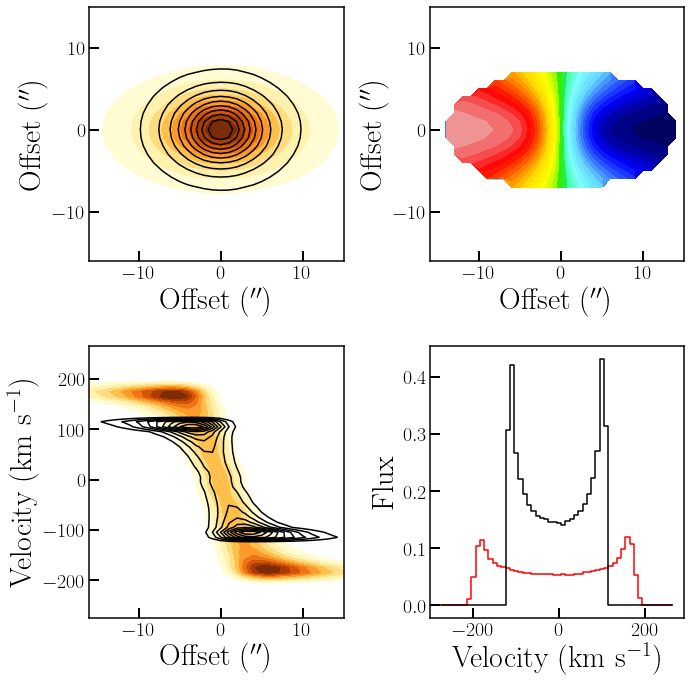

Doing chain 1
     Chain has not converged - Accept rate: 0.13230769230769232
Chain converged: LL: -23.996346348273484 - Accept rate:0.2723076923076923
Best chain so far!
Best fit:
  PA: 90.0
  Xc: 12.000146134123751
  Yc: 9.99986038337797
  Vsys: -5.551700494696028
  inc: 61.224164569131524
  totflux: 26.09773069413567
  PeakFlux_exp: 1.0
  Rscale_exp: 4.82032630214406
  V0: 57.645594614894925
  V1: 228.57660109333347
  V2: 194.2521689453765
  V3: 221.73801448675823
  V4: 192.27074559142355
Starting final chain
Final best fit values and 1sigma errors:
  PA: 90.0359100446065 + 0.6762046615867803 - 0.5980326026767244
  Xc: 12.000137910967968 ± 3.2680183958966325e-05
  Yc: 9.999866352940021 + 2.9681690154603757e-05 - 3.377010000704672e-05
  Vsys: -4.9499680183616155 + 1.0711620954579053 - 0.6615178682403249
  inc: 60.220268961965246 + 1.9831201121187476 - 0.9510217934461451
  totflux: 25.81562675640119 + 0.8466739177543268 - 0.7027351422554666
  PeakFlux_exp: 1.0 (Fixed)
  Rscale_exp: 4.

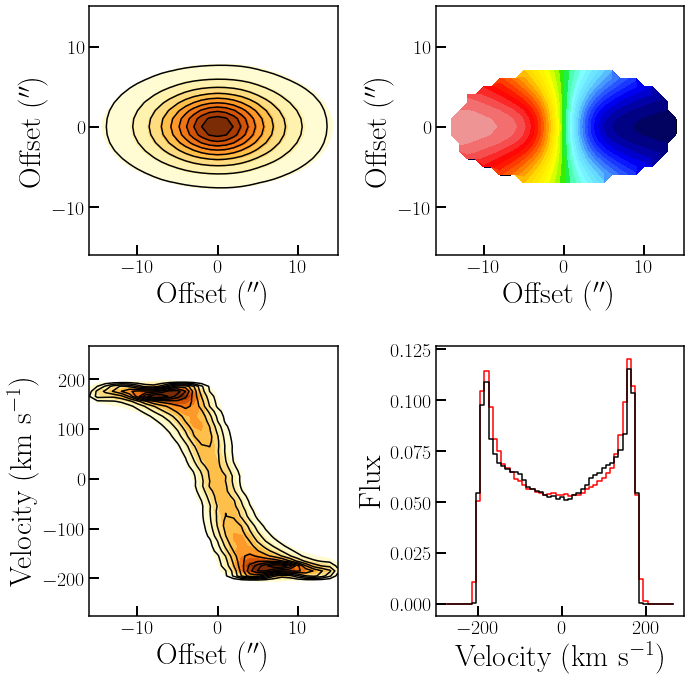

In [12]:
fit.run()

As you can see we get a very nice fit, with the inclination and scale radius (and the other parameters) correct within the errors! One could go ahead and run a longer chain, and enable plotting of the corner plots to visulaise covariances etc, but we leave this as an exercise to the user.

## Using more complex velocity and surface brightness profile shapes

Often an exponential disc/tilted ring type velocity structure does not capture the physics you want to include in your modelling. In these cases KinMS_fitter has a simple way to help - via the `sb_profs` and `velocity_profs` modules.

In [5]:
from kinms_fitter.sb_profs import sb_profs
from kinms_fitter.velocity_profs import velocity_profs  

Examples of current functionality of these are shown below - adding new features is easy however, so get in contact if your favourite form is not avalible!

### Surface brightness profiles

First, lets reproduce a basic exponential disc, as used by default in KinMS_fitter. You can call the `sb_profs.expdisk` profile, and supply guesses, and limits, for its two free parameters (the central brightness ($I_0$), and the scale radius ($r_{scale}$) as below. 


$
\begin{align}
\large I_{gas}(r) = I_0 e^{\frac{-r}{r_{scale}}}
\end{align}
$

If you are only passing a single function to KinMS_fitter then you should fix the flux normalisation, as that will be handled seperately by fitting the total flux of the model. If you supply multiple components then you should fix one, and fit the other fluxes relative to that. 

In [20]:
guesses=[1,10]
mymodel=[sb_profs.expdisk(guesses=guesses,minimums=[0,0],maximums=[100,20],fixed=[True,False])]

To demonstrate this profile, we can define a radius array, and plot the SB profile resulting:

Text(0, 0.5, 'Brightness')

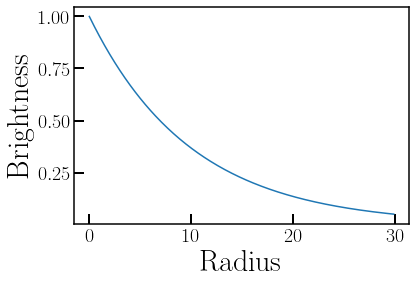

In [22]:
import matplotlib.pyplot as plt
import numpy as np
r=np.arange(0,30,0.1)
plt.plot(r,sb_profs.eval(mymodel,r,guesses)) 
plt.xlabel("Radius")
plt.ylabel("Brightness")

As you may have noted above, mymodel is actually a list. As such we can combine many surface profiles together by adding them to the list! Below we add a second, more concentrated exponential disc. Note we only fix one of the fluxes!

In [37]:
mymodel=[sb_profs.expdisk(guesses=[1,10],minimums=[0,0],maximums=[100,20],fixed=[True,False]),\
         sb_profs.expdisk(guesses=[1,3],minimums=[0,0],maximums=[100,20])]

Lets see what that looks like... (total result in blue, the two components are plotted as orange and green lines).

Text(0, 0.5, 'Brightness')

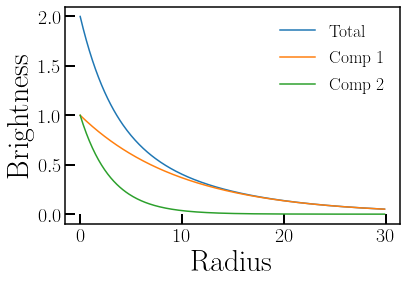

In [38]:
guesses=np.concatenate([i.guess for i in mymodel]) # this line just sets the parameters to the guesses inputed above
plt.plot(r,sb_profs.eval(mymodel,r,guesses),label='Total')
plt.plot(r,sb_profs.eval([mymodel[0]],r,guesses[0:2]),label='Comp 1')
plt.plot(r,sb_profs.eval([mymodel[1]],r,guesses[2:]),label='Comp 2')
plt.legend(frameon=False)
plt.xlabel("Radius")
plt.ylabel("Brightness")

Instead of an exponential, maybe we add in a gaussian ring! Here the free parameters are the gaussians peak, its central radius, and width.

In [41]:
mymodel=[sb_profs.expdisk(guesses=[1,10],minimums=[0,0],maximums=[100,20],fixed=[True,False]),\
         sb_profs.gaussian(guesses=[2,10,1],minimums=[0,0,0],maximums=[10,100,20])]

Text(0, 0.5, 'Brightness')

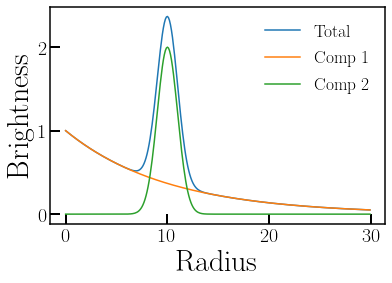

In [42]:
guesses=np.concatenate([i.guess for i in mymodel]) # this line just sets the parameters to the guesses inputed above
plt.plot(r,sb_profs.eval(mymodel,r,guesses),label='Total')
plt.plot(r,sb_profs.eval([mymodel[0]],r,guesses[0:2]),label='Comp 1')
plt.plot(r,sb_profs.eval([mymodel[1]],r,guesses[2:]),label='Comp 2')
plt.legend(frameon=False)
plt.xlabel("Radius")
plt.ylabel("Brightness")

Finally, you can add multiplicative components to the model, like a cutoff, to here to simulate a hole in the centre of a galaxy. The free parameters are radius of the start and end of the cutoff.

Text(0, 0.5, 'Brightness')

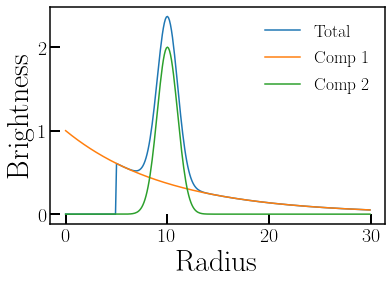

In [51]:
mymodel=[sb_profs.expdisk(guesses=[1,10],minimums=[0,0],maximums=[100,20],fixed=[True,False]),\
         sb_profs.gaussian(guesses=[2,10,1],minimums=[0,0,0],maximums=[10,100,20]),\
         sb_profs.cutoff(guesses=[0,5],minimums=[0,1],maximums=[10,20])]

guesses=np.concatenate([i.guess for i in mymodel]) # this line just sets the parameters to the guesses inputed above
plt.plot(r,sb_profs.eval(mymodel,r,guesses),label='Total')
plt.plot(r,sb_profs.eval([mymodel[0]],r,guesses[0:2]),label='Comp 1')
plt.plot(r,sb_profs.eval([mymodel[1]],r,guesses[2:5]),label='Comp 2')
plt.legend(frameon=False)
plt.xlabel("Radius")
plt.ylabel("Brightness")

Note: you cant plot component 3 alone, as it is a multiplicative component, but its effect is clear in the blue "total" line.

In this way you can add surface brightness components together, and fit their free parameters with KinMS_fitter.

<b>Warning: pay careful attention to areas where you could create parameter degeneracies. For instance multiple flux components, or when you have two similar profiles (e.g. our double exponential, above) that could swap positions. You should fix parameters, or constain the minimums/maximums where needed to avoid this!</b>

### Velocity profiles

Adding different velocity profiles works similarly to adding surface brightness components, but using `kinms_fitter.velocity_profs`. At the moment four different types of velocity profiles exist in the module, but more will be added as time goes on. These are:

* A tilted ring (i.e. piecewise linear) velocity curve with an arbitary number of free parameters. This has one set of  hyperparameters - the radii of the rings to fit. Guesses (and limits) required for the velocity of each ring in km/s.<p>

* An arctan function $V(r)=\frac{2V_{max}}{\pi}arctan\frac{R}{R_{turn}}$. This profile has no hyperparameters, and requires guesses (and limits) for $V_{max}$ in km/s and $R_{turn}$ in arcseconds.<p>

* A Keplarian $V(r)=\sqrt{\frac{GM}{R}}$. This profile has the distance to the galaxy as a hyperparameter (to convert the radius in arcseconds to parsecs), and requires a single input guess (with limits) for M, in units of $\log_{10}$ solar masses. <p>
    
* An MGE potential (see https://www-astro.physics.ox.ac.uk/~mxc/software/#mge). Input hyperparameters are the MGE surface brightness, radius and axial ratio (q). Either two or three fitted parameters can either be supplied -  the M/L in the band the MGE was created in (in Msun/Lsun units), the inclination of the stellar body, and (optionally) the black hole mass. <i> Future improvements will allow you to tie the inclination of the stars to the inclination of the gas, making this a hyperparameter here.</i>
    
When multiple velocity profiles are included in your model, the final result will have the profiles added in quadarature. Some examples are shown below:
    
Firstly, we can duplicate the tilted ring type approach set as the default:

In [55]:
bincentroids=np.arange(0,30,5) # radii of the bin centroids
mymodel = [velocity_profs.tilted_rings(bincentroids,guesses=[0,250,260,260,250,230],minimums=np.zeros(bincentroids.size),maximums=np.ones(bincentroids.size)*500.)]

And we can plot this, as before.

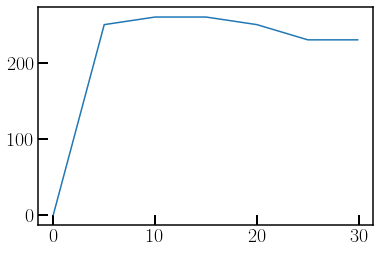

In [57]:
params=np.concatenate([i.guess for i in mymodel])
plt.plot(r,velocity_profs.eval(mymodel,r,params)) 
plt.xlabel("Radius")
plt.ylabel("Velocity (km/s)")

Now one could imagine adding a central point mass (e.g. a SMBH):

In [58]:
mymodel=[velocity_profs.tilted_rings(bincentroids,guesses=[0,250,260,260,250,230],minimums=np.zeros(bincentroids.size),maximums=np.zeros(bincentroids.size)),\
         velocity_profs.keplarian(distance=16.5,guesses=[8],minimums=[5],maximums=[10])]

Plotting this results in the following:

Text(0, 0.5, 'Velocity (km/s)')

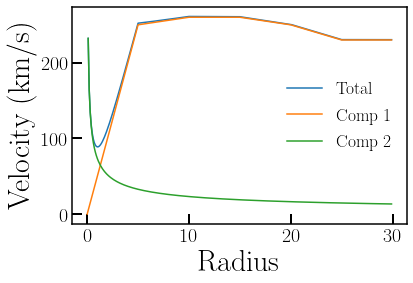

In [64]:
params=np.concatenate([i.guess for i in mymodel])
plt.plot(r,velocity_profs.eval(mymodel,r,params),label="Total")
plt.plot(r,velocity_profs.eval([mymodel[0]],r,params[0:-1]),label='Comp 1')
plt.plot(r,velocity_profs.eval([mymodel[1]],r,params[-1:]),label='Comp 2')
plt.legend(frameon=False)
plt.xlabel("Radius")
plt.ylabel("Velocity (km/s)")

One could replace the tilted rings with an arctangent as so:

Text(0, 0.5, 'Velocity (km/s)')

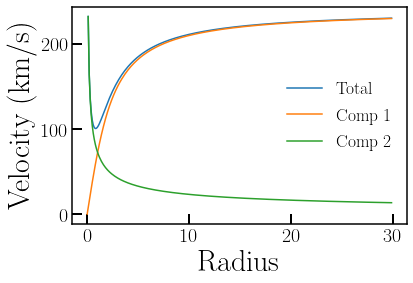

In [67]:
mymodel=[velocity_profs.arctan(guesses=[240,2],minimums=[0,0],maximums=[500,20]),\
         velocity_profs.keplarian(distance=16.5,guesses=[8],minimums=[5],maximums=[10])]

params=np.concatenate([i.guess for i in mymodel])
plt.plot(r,velocity_profs.eval(mymodel,r,params),label="Total")
plt.plot(r,velocity_profs.eval([mymodel[0]],r,params[0:-1]),label='Comp 1')
plt.plot(r,velocity_profs.eval([mymodel[1]],r,params[-1:]),label='Comp 2')
plt.legend(frameon=False)
plt.xlabel("Radius")
plt.ylabel("Velocity (km/s)")

Or finally (for now) by using an MGE model of the stellar potential:

Text(0, 0.5, 'Velocity (km/s)')

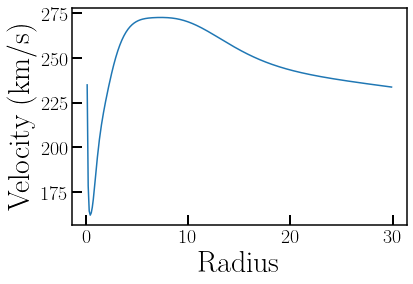

In [70]:
surf=np.array([25551.5, 21118.8, 7436.97, 12016.7, 5862.67, 741.344, 807.669, 212.118])
sigma=np.array([0.226508, 0.661430, 1.30613, 2.17346, 4.76300, 11.3177, 19.2433, 48.5786])
qobs=np.array([0.514866, 0.607566, 0.887495, 0.576108, 0.837162, 0.440516, 0.779643, 0.821153])

mymodel=[velocity_profs.mge_vcirc(surf,sigma,qobs,16.5,guesses=[2,70,8],minimums=[0.1,0,7],maximums=[10,90,10])]

params=np.concatenate([i.guess for i in mymodel])
plt.plot(r,velocity_profs.eval(mymodel,r,params))
plt.xlabel("Radius")
plt.ylabel("Velocity (km/s)")


## Fitting with these velocity/surface brightness profiles

To demonstrate fitting with these surface brightness profiles we will work with CARMA data of a real galaxy, NGC5866.  The gas in this galaxy is distributed in two rings (likely due to a bar), which we will fit with double gaussian surface brightness profiles. We will model the rotation with an arctangent.

First we load in the cube (handily hosted by NED for us).

In [9]:
import numpy as np
from kinms_fitter import kinms_fitter
from kinms_fitter.sb_profs import sb_profs
from kinms_fitter.velocity_profs import velocity_profs 
cube = "http://ned.ipac.caltech.edu/img/2013MNRAS.432.1796A/NGC_5866:I:CO10:a2013.fits.gz"

fit=kinms_fitter(cube,spatial_trim=[19,83,19,83],spectral_trim=[15,90],linefree_chans=[3,15]) # load in your cube, and trim it if needed
fit.pa_guess=125
fit.xc_guess=226.622412
fit.yc_guess=55.7631136
fit.vsys_guess=752.79
fit.inc_guess=88.76
fit.totflux_guess=171.74


Now we can specify the surface brightness profile. Note how we fix one of the surface brightness variables (so the other becomes a relative flux), and set the minima/maxima so the two components cannot swap!

In [10]:
fit.sb_profile=[sb_profs.gaussian(guesses=[1,2.38,2.21],minimums=[0,0.1,0],maximums=[10,10,10],fixed=[True,False,False]),\
               sb_profs.gaussian(guesses=[0.03,25.86,4.92],minimums=[0,23,0],maximums=[10,30,10])]

The velocity function is a simple arctan:

In [11]:
fit.vel_profile=[velocity_profs.arctan(guesses=np.array([260,0.96]),minimums=np.array([50,0.01]),maximums=[370,10])]

Now we can run the fit, this time with 10,000 steps. The initial guesses are reasonable, but not perfect. 

One model took this long: 0.2878868818283081


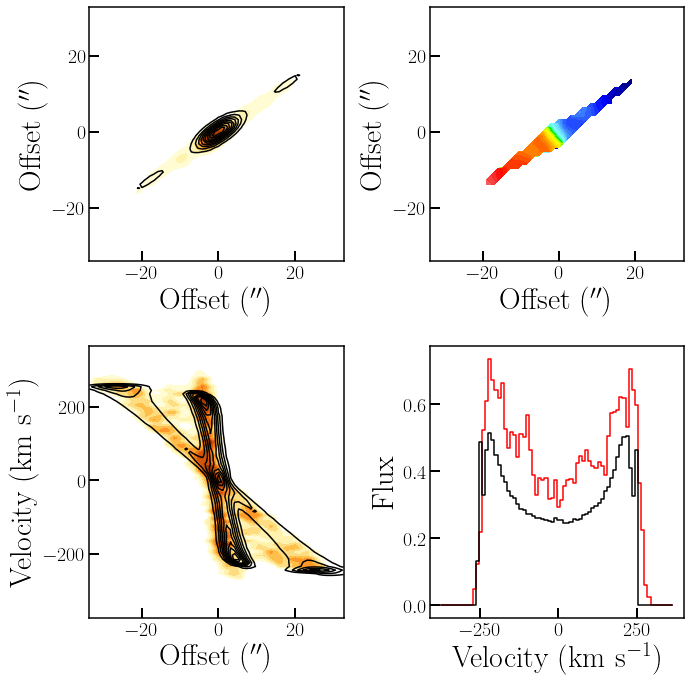

Doing chain 1
     Chain has not converged - Accept rate: 0.25142857142857145
Chain converged: LL: -14.23462471968632 - Accept rate:0.4357142857142857
Best chain so far!
Best fit:
  PA: 123.68219718839092
  Xc: 226.62210590508627
  Yc: 55.76277464180863
  Vsys: 766.7626492978005
  inc: 88.2985809242142
  totflux: 229.63535575699194
  PeakFlux_gauss: 1.0
  Mean_gauss: 2.675260258594085
  sigma_gauss: 1.3988111036685433
  PeakFlux_gauss: 0.02901699629762156
  Mean_gauss: 24.103393071844327
  sigma_gauss: 6.259952358854468
  Vmax: 273.9921375695974
  Rturn: 0.9021192183781488
Starting final chain
Final best fit values and 1sigma errors:
  PA: 125.79065178989514 ± 2.578037954982989
  Xc: 226.62208911279805 + 0.0001574629941103467 - 0.00028942295796241524
  Yc: 55.76274424165254 + 0.00016521013591841438 - 0.00018754440451118626
  Vsys: 766.2281876599054 + 12.278566490426556 - 15.940505616413134
  inc: 87.18436099658354 + 1.06827264396658 - 1.9306377601148341
  totflux: 168.14149068476158 ± 

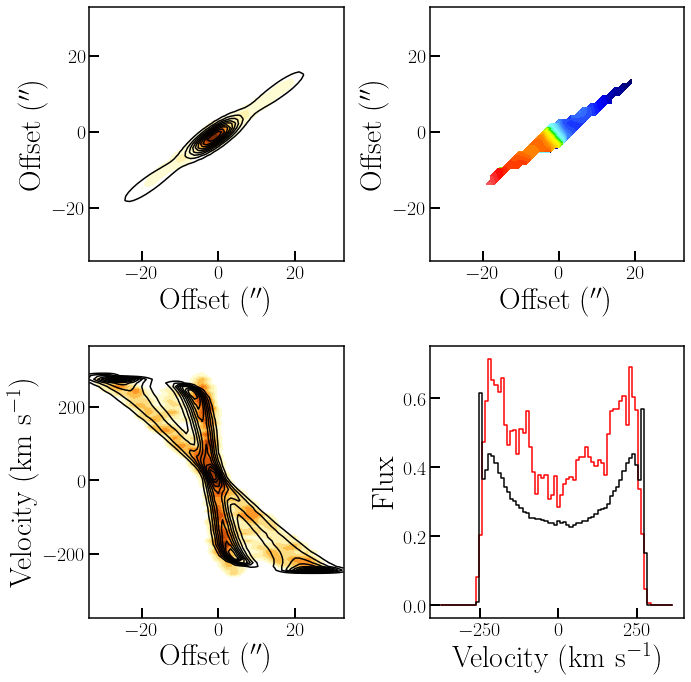

In [12]:
fit.niters=10000
fit.nprocesses=1
bestvals, besterrs, outputvalue, outputll = fit.run()

This final model, while still not perfect (likely due to the material between the rings which was not included in our model) hopefully gives you a good idea of how to use the flexible rotation curve/surface brightness profile functions!
